In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

__file__ = '/content/drive/Othercomputers/MacBook_Air/path-finding-rl/data'

Mounted at /content/drive


## Env
- 경로 이동 제한 사항 반영: del apply_action() 수정
- def grid_box(self):  # 그리드 박스 초기화 용도로 정의
- 그리드값 변경
  - target_gridval (목표물)  = 10, 9, 8, ...
  - curloc_gridval (현 위치) = 1
  - default_gridval (기본)   = 0
  - rack_gridval (선반)      = -1
  - obs_gridval (장애물)     = -10
- 종료 조건
  - **그리드월드 밖**으로 나가는 경우 **종료하지 않음**
  - **장애물**에 부딪히는 경우 **종료**

In [2]:
from string import ascii_uppercase
import numpy as np
import pandas as pd
import os
import random
from datetime import datetime
import pytz
import matplotlib.pyplot as plt

###################################
# 보상 Reward
move_reward = -1  # 0.1
obs_reward = -10  # 0.1
goal_reward = 10  # 10
###################################
# 그리드값
# target_gridval = 10, 9, 8... # 목표물: 10, 9, 8, ...
curloc_gridval  = 1            # 현 위치: 1
default_gridval = 0            # 기본: 0
rack_gridval    = -1           # 선반: -1
obs_gridval     = -10          # 장애물: -10
###################################
# train / test 모드 지정
train_mode = True
###################################
print('reward:' , move_reward, obs_reward, goal_reward)

#__file__ = '/home/ogangza/heung_path_finding/path-finding-rl/data'

local_path = os.path.abspath(os.path.join(os.path.dirname(__file__)))

class Simulator:
    def __init__(self):
        # Load train or test data
        if train_mode:  # 훈련 데이타 읽기
           self.files = pd.read_csv(os.path.join(local_path, "data/factory_order_train.csv"))
           print('data/factory_order_train.csv used')
        else:           # 테스트 데이터 읽기
           self.files = pd.read_csv(os.path.join(local_path, "data/factory_order_test.csv"))
           print('data/factory_order_test.csv used')
        ##########################################################################################
        self.height = 10  # 그리드 높이
        self.width = 9    #  그리드 너비
        self.inds = list(ascii_uppercase)[:17]  # A ~ Q alphabet list

    def set_box(self):  # 선반 위치, 목적지 그리드값 설정. 목적지 리스트 생성
        box_data = pd.read_csv(os.path.join(local_path, "./data/box.csv"))
        for box in box_data.itertuples(index = True, name ='Pandas'):  # 선반 위치: 그리드값 = rack_gridval
            self.grid[getattr(box, "row")][getattr(box, "col")] = rack_gridval
        order_item = list(set(self.inds) & set(self.items))
        order_csv = box_data[box_data['item'].isin(order_item)]
        for i, order_box in enumerate(order_csv.itertuples(index = True, name ='Pandas')):  # 목적지: 그리드값 = target_gridval
            self.grid[getattr(order_box, "row")][getattr(order_box, "col")] = 10 - i
            self.local_target.append([getattr(order_box, "row"), getattr(order_box, "col")])  # 목적지 리스트 생성: local_target
        # self.local_target.sort() # 불필요. 인풋 데이터 A, B, C순 정렬되어 있음... 정렬 필요시 코드 바꾸어야 함
        self.local_target.append([9,4]) # 목적지 리스트에 최종 목적지(9,4) 추가
        self.local_target_original = self.local_target.copy()  # gif 생성을 위해 추가.  에피소드의 경로 저장
        self.target_length = len(self.local_target_original)  # 목적지 그리드값 10, 9, 8, ... 지정 위해 추가
        self.grid[9,4] = 10 + 1 - self.target_length  # 최종 목적지 [9,4] 그리드값 지정 위해 추가

    def set_obstacle(self):  # 장애물 위치 그리드값 설정 = obs_gridval
        obstacles_data = pd.read_csv(os.path.join(local_path, "./data/obstacles.csv"))
        for obstacle in obstacles_data.itertuples(index = True, name ='Pandas'):
            self.grid[getattr(obstacle, "row")][getattr(obstacle, "col")] = obs_gridval

    def grid_box(self):  # 그리드 박스 초기화 용도로 정의: 선반, 목적지, 장애물 그리드값 초기화
        box_data = pd.read_csv(os.path.join(local_path, "./data/box.csv"))
        for box in box_data.itertuples(index = True, name ='Pandas'):  # 선반 위치: 그리드값 = rack_gridval
            self.grid[getattr(box, "row")][getattr(box, "col")] = rack_gridval
        order_item = list(set(self.inds) & set(self.items))
        order_csv = box_data[box_data['item'].isin(order_item)]
        for i, order_box in enumerate(order_csv.itertuples(index = True, name ='Pandas')):  # 목적지: 그리드값 = target_gridval
            self.grid[getattr(order_box, "row")][getattr(order_box, "col")] = 10 - i
        self.grid[9,4] = 10 + 1 - self.target_length  # 최종 목적지 [9,4] 그리드값 지정 위해 추가
        self.set_obstacle()  # 장애물 위치 그리드값 설정 = obs_gridval
        
    def reset(self, epi):  # 에피소드 시작시 12개 값 초기화
        self.epi = epi                                            #1. 에피소드 번호 받기
        self.items = list(self.files.iloc[self.epi])[0]           #2. 에피소드의 목적지 받기: [ 'H', 'L', 'M']
        ####################################################################################
        # coin = random.randint(0,16)
        # self.items = [chr(coin+65)]  # A~Q 까지 1개 랜덤으로 받아서 items에 1개 넣어주기, 반복 횟수는 main의 epochs 조절하기
        ####################################################################################
        self.cumulative_reward = 0                                #3. 누적 보상값 = 0
        self.terminal_location = None                             #4. 최초 목적지
        self.local_target = []                                    #5. 목적지 리스트 초기화
        self.actions = []                                         #6. 지나온 경로 리스트 초기화
        self.grid = np.zeros((self.height, self.width), dtype="float16")  #7. 그리드월드 전체 그리드값(default_gridval) 초기화
        self.set_box()                                            #8. 선반 위치, 목적지 그리드값 설정. 목적지 리스트 생성
        self.set_obstacle()                                       #9. 장애물 그리드값 설정
        ######################
        # print('최초 그리드맵:')  # 그리드맵 확인
        # print(self.grid.reshape(10,9))
        ######################
        self.curloc = [9, 4]                                      #10. 현재 위치를 출발점으로 세팅
        self.grid[int(self.curloc[0])][int(self.curloc[1])] = curloc_gridval  #11. 현재 위치(출발점) 그리드값 세팅
        self.done = False                                         #12. 경로 찾기 종료 여부 = False
        self.goal_ob_reward = False                      # (추가) #13. 최종 목적지 도착 여부 = False
        ######################
        # print('현 위치 추가:')   # 그리드맵 확인
        # print(self.grid.reshape(10,9))
        ######################
        return self.grid

    def apply_action(self, action, cur_x, cur_y):  # action에 따른 새 좌표값 반환
        new_x = cur_x
        new_y = cur_y
        if action == 0:          # up
            #new_x = cur_x - 1
            new_x = self.move_up(cur_x, cur_y, new_x, new_y)
        elif action == 1:        # down
            #new_x = cur_x + 1
            new_x = self.move_down(cur_x, cur_y, new_x, new_y)
        elif action == 2:        # left
            #new_y = cur_y - 1
            new_y = self.move_left(cur_x, cur_y, new_x, new_y)
        else:                    # right
            #new_y = cur_y + 1
            new_y = self.move_right(cur_x, cur_y, new_x, new_y)
        return int(new_x), int(new_y)
    
    # >>> 현재 위치에서 이동이 불가한 위치 추가 (시작) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    def move_up(self, cur_x, cur_y, new_x, new_y):  # action == 0:
        if cur_x in [6,5,4,3,2] and cur_y in [0,8]:
            pass
        else:
            new_x = cur_x - 1
        return new_x
    def move_down(self, cur_x, cur_y, new_x, new_y): # action == 1:
        if cur_x in [1,2,3,4,5] and cur_y in [0,8]:
            pass
        else:
            new_x = cur_x + 1
        return new_x
    def move_left(self, cur_x, cur_y, new_x, new_y): # left elif action == 2:
        if cur_y in [1,2,3,4,5,6,7,8] and cur_x == 0:
            pass
        else:
            new_y = cur_y - 1
        return new_y
    def move_right(self, cur_x, cur_y, new_x, new_y): # right else: action == 3:
        if cur_y in [0,1,2,3,4,5,6,7] and cur_x == 0:
            pass
        else:
            new_y = cur_y + 1
        return new_y
    # >>> 추가 (끝) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    def get_reward(self, new_x, new_y, out_of_boundary):  # action에 의해 이동시 얻는 보상
        if any(out_of_boundary):                                        # 바깥으로 나가는 경우
            reward = obs_reward
        else:
            if self.grid[new_x][new_y] in [rack_gridval, obs_gridval]:  # 선반이나 장애물에 부딪히는 경우
                reward = obs_reward
            elif new_x == self.terminal_location[0] and new_y == self.terminal_location[1]:  # 현재 목적지에 도달한 경우
                reward = goal_reward
            else:                                                       # 그냥 움직이는 경우 
                reward = move_reward
        return reward

    def step(self, action):  # action에 따른 이동 실행
        self.terminal_location = self.local_target[0]           # 목적지 리스트의 첫 번째 요소를 목적지로 설정
        cur_x, cur_y = self.curloc                              # 현재 위치 기억
        new_x, new_y = self.apply_action(action, cur_x, cur_y)  # 다음 위치 받기
        self.actions.append((cur_x, cur_y))                     # 현재 위치(지나온 위치)를 경로 리스트에 추가
        self.goal_ob_reward = False                             # 최종 목적지에 도착한 경우에 True. self.reset()에서 초기화
        out_of_boundary = [new_x < 0, new_x >= self.height, new_y < 0, new_y >= self.width]  # 그리드월드 밖으로 나갔는가? OB = True

        if any(out_of_boundary) or self.grid[new_x][new_y] == rack_gridval:  #1. 바깥으로 나가는 경우, 빈 선반에 부딪치는 경우 종료하지 않음
            #print('OB')
            reward = self.get_reward(new_x, new_y, out_of_boundary)
            new_x = cur_x  # 종료 처리할 경우 코멘트 처리
            new_y = cur_y  # 종료 처리할 경우 코멘트 처리
            ######################################################종료 처리할 경우 실행
            #self.done = True                             # while loop 종료
            #self.grid_box()                              # 선반, 목적지, 장애물 그리드값 초기화
            #self.actions.append((new_x,new_y))           # 경로 리스트에 최종 위치 추가. (주의) 좌표값이 그리드월드를 벗어나는 값 발생!
            ######################################################
        else:
            if self.grid[new_x][new_y] == obs_gridval:  #2. 장애물에 부딪히는 경우 종료
                # print('장애물')
                reward = self.get_reward(new_x, new_y, out_of_boundary)
                # new_x = cur_x  # 종료 처리할 경우 코멘트 처리
                # new_y = cur_y  # 종료 처리할 경우 코멘트 처리
                ###################################################종료 처리할 경우 실행
                self.done = True                           # while loop 종료
                self.grid[cur_x][cur_y] = default_gridval  # 현 위치의 그리드값을 기본값으로 초기화
                self.grid_box()                            # 선반, 목적지, 장애물 그리드값 초기화
                self.grid[new_x][new_y] = curloc_gridval   # 현 위치(장애물)에서 종료되었음을 표시. 원래는 장애물이었음
                self.actions.append((new_x,new_y))         # 경로 리스트에 최종 위치 추가
                ###################################################
            elif new_x == self.terminal_location[0] and new_y == self.terminal_location[1]:  #3. 현재 목적지에 도착한 경우 다음 목적지 설정
                #print('목적지 도착')
                reward = self.get_reward(new_x, new_y, out_of_boundary)
                if [new_x, new_y] == [9, 4]:            #3-1. 최종 목적지에 도착한 경우 종료
                    self.done = True                       # while loop 종료
                    self.goal_ob_reward = True             # True = 1 (OB, 장애물 종료 처리 할 경우 self.done=True가 많아지므로 이때 사용)
                    self.actions.append((new_x,new_y))     # 경로 리스트에 최종 위치 추가

                self.local_target.remove(self.local_target[0])  # 다음 목적지 설정. 최종 목적지에 도착한 경우에는 마지막 요소인 [9,4]를  제거
                self.grid[cur_x][cur_y] = default_gridval  # 현 위치의 그리드값을 기본값으로 초기화
                self.grid_box()                            # 선반, 목적지, 장애물 그리드값 초기화
                self.grid[new_x][new_y] = curloc_gridval   # 현 위치(목적지)에서 종료되었음을 표시. 원래는 목적지이었음
                self.curloc = [new_x, new_y]               # 새로 도착한 위치를 현재 위치로 변경
            else:                                       #4. 그냥 움직이는 경우
                #print('이동')
                reward = self.get_reward(new_x, new_y, out_of_boundary)
                self.grid[cur_x][cur_y] = default_gridval  # 현 위치의 그리드값을 기본값으로 초기화
                self.grid_box()                            # 선반, 목적지, 장애물 그리드값 초기화
                self.grid[new_x][new_y] = curloc_gridval   # 현 위치에서 종료되었음을 표시
                self.curloc = [new_x,new_y]

        #reward = self.get_reward(new_x, new_y, out_of_boundary)  # 각 경우에 받는 것으로 처리!!
        self.cumulative_reward += reward
        return self.grid, reward, self.cumulative_reward, self.done


reward: -1 -10 10


## Agent
- def test_action(self, obs): 추가

In [3]:
import collections
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ReplayBuffer():  # 리플레이 버퍼: 경험 저장소
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):  # 리플레이 버퍼(메모리)를 경험(transition)으로 채우기
        self.buffer.append(transition)
    
    def sample(self, n):  # memory.sample(batch_size)로 사용
        mini_batch = random.sample(self.buffer, n)  # 미니배치 샘플링
        '''
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        for transition in mini_batch:  # 경험의 각 요소들을 각각의 미니배치로 구성
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
        '''
        state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in mini_batch])
        action_batch = torch.Tensor([a for (s1,a,r,s2,d) in mini_batch])
        reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in mini_batch])
        state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in mini_batch])
        done_batch = torch.Tensor([d for (s1,a,r,s2,d) in mini_batch])

        return state1_batch, action_batch, reward_batch, state2_batch, done_batch
    
    def size(self):  # 메모리 크기
        return len(self.buffer)

class Qnet(nn.Module):
    '''##### Linear 모델 #####
    def __init__(self):
        super(Qnet, self).__init__()

        in_size = 90  # input 크기
        L1 = 250
        L2 = 150
        out_size  = 4

        self.fc1 = nn.Linear(in_size, L1)
        self.fc2 = nn.Linear(L1, L2)
        self.fc3 = nn.Linear(L2, out_size)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    '''
    ##### Convolution 모델 #####
    def __init__(self):
        super(Qnet, self).__init__()

        self.conv1 = nn.Conv2d(4, 32, 3, 1) #### 1이었던 부분을 4로 변경
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = x.to(device)               # (N, 4, 10, 9)
        x = F.relu(self.conv1(x))      # (N, 32, 8, 7)
        x = F.relu(self.conv2(x))      # (N, 64, 6, 5)
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)        # (N, 64, 30)
        x = F.relu(self.fc1(x))        # (N, 1920) -> (N, 128)
        x = self.fc2(x)                # (N, 128)  -> (N, 4)
        return x

    def sample_action(self, obs, epsilon):  # Qnet()을 실행해서 모든 action에 대한 Qval을 구한 후 action 선택
        out = self.forward(obs)  # out = Q_value, obs = state = 그리드맵
        coin = random.random()  # e-greedy로 action 선택
        if coin < epsilon:
            return random.randint(0,3)
        else : 
            return out.argmax().item()
    
    def test_action(self, obs):  # Qnet()을 실행해서 모든 action에 대한 Qvalue을 구한 후 action 선택
        out = self.forward(obs)  # out = Q_value, obs = state = 그리드맵
        return out.argmax().item()

def train(q, q_target, memory, optimizer):  # 메모리에 경험이 미니배치 크기 이상 쌓이면 미니배치 훈련 시작
    '''
    for i in range(10):
        s, a, r, cr, s_prime, done_mask, gr = memory.sample(batch_size)
        q_out = q(s)
        q_a = q_out.gather(1,a.to(device))
        
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r.to(device) + gamma * max_q_prime * done_mask.to(device)
        
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    '''
    s,a,r,s_prime,done_mask = memory.sample(batch_size)  # 메모리에서 미니배치를 뽑기: batch_size=1600
    Q1 = q(s)  # Qnet의 Qvalue
    X = Q1.gather(dim=1,index=a.long().unsqueeze(dim=1).to(device)).squeeze() # Qnet의 Qvalue 변환
    with torch.no_grad():
        Q2 = q_target(s_prime)
    Y = r.to(device) + gamma * done_mask.to(device) * torch.max(Q2,dim=1)[0]
    loss = F.smooth_l1_loss(X, Y.detach())
    #loss = nn.MSELoss(X.to(torch.float32), Y.detach().to(torch.float32))  # 손실함수 변경. target.detach()로 변경
    optimizer.zero_grad()  # gradient값 초기화
    loss.backward()  # 자동미분
    optimizer.step()  # gradient 업데이트
    return loss.item()

## Main: DQN...
  - GPU를 사용할 경우 구현
  - 학습한 모델 불러올 수 있는 코드 추가
    - '#' 제거하고 실행시키면 됨

tensor in cuda
data/factory_order_train.csv used
종료: done = True ... j = 100  move = 3
종료: done = True ... j = 300  move = 8
종료: done = True ... j = 400  move = 16
종료: done = True ... j = 700  move = 19
종료: done = True ... j = 1400  move = 15
종료: done = True ... j = 1800  move = 21
종료: done = True ... j = 1900  move = 11
종료: done = True ... j = 2900  move = 3
종료: done = True ... j = 5000  move = 7
종료: done = True ... j = 6200  move = 7
종료: done = True ... j = 7100  move = 18
종료: done = True ... j = 7700  move = 11
종료: done = True ... j = 7800  move = 5
종료: done = True ... j = 8500  move = 11
종료: done = True ... j = 8600  move = 3
종료: done = True ... j = 8900  move = 6
종료: done = True ... j = 11000  move = 8
종료: done = True ... j = 11400  move = 11
종료: done = True ... j = 11700  move = 12
종료: done = True ... j = 11900  move = 7
종료: done = True ... j = 12000  move = 3
종료: done = True ... j = 12200  move = 5
종료: done = True ... j = 12300  move = 5
종료: done = True ... j = 13000  move = 7
종

Text(0, 0.5, 'Moves')

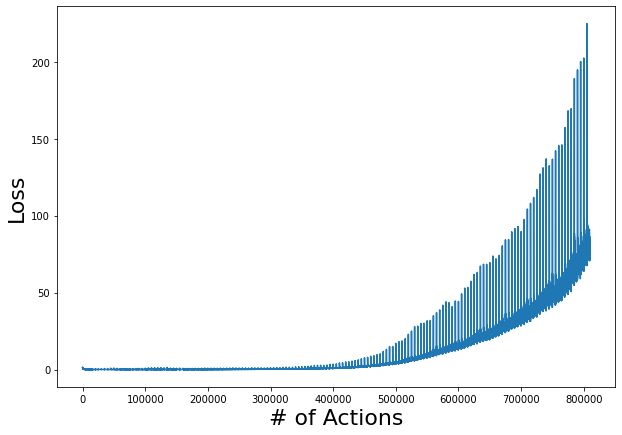

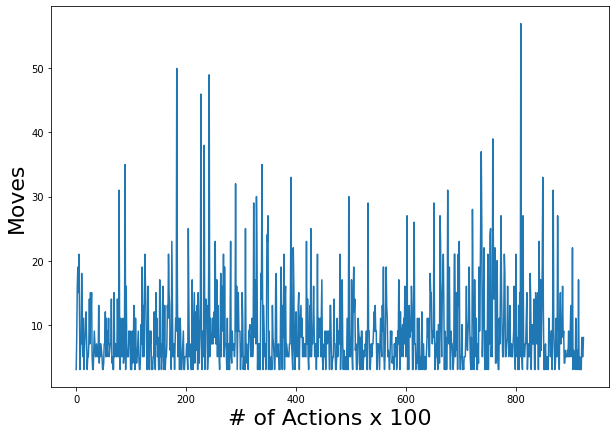

In [5]:
#def main(): # DQN... Total Path 학습 모델

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU를 사용할 경우 ???
print('tensor in', device)  # GPU 사용 확인
# PATH = '/content/drive/MyDrive/aiffelthon/data/model_conv_colab.pt'
PATH = __file__ + '/model_conv_dataset.pt' ## PATH 경로 쉽게 수정
##############################################
tz = pytz.timezone('Asia/Seoul')
cur_time = datetime.now(tz)
start_time = cur_time.strftime("%H:%M:%S")

### 중요 Hyperparameters #####################
buffer_limit  = 200000     #1. 50000
batch_size    = 1500        #2. 32
learning_rate = 0.00025      #3. 0.0005
sync_freq = 5000            #4. q 네트워크 파라미터를 q_target 네트워크에 복사하는 주기
train_start = 20000   # (추가)
##############################################
env = Simulator()  # 데이터셋 읽기. 그리드월드 크기 지정
q = Qnet()
q.to(device)
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

train_model_load = False  # 학습한 모델을 불러와서 계속 학습시키고자 하는 경우 True로 바꾼다!!
if train_model_load:
    ###############################################################
    ## 학습한 모델 불러오기
    ###############################################################
    checkpoint = torch.load(PATH)
    q.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    q.train()
###############################################################
q_target = Qnet()
q_target.to(device)
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

### Hyperparameters #####################
gamma = 0.99             #5. 0.98
####################################################################
# epochs = len(env.files)  #6. 훈련용 데이터 갯수
epochs = 90000  # 한 군데 갔다 오는 경우에 사용. 반복 횟수는 각자 지정
####################################################################
losses = []
moves = []
max_moves = 350          #7.
print_interval = 5000    #8.
j = 0
goal_ob_reward_count = 0 #9. epoch를 반복하면서 finish 카운팅
# epsilon = 0.3            #10. annealing 대신 고정
loss = 0.0
##############################################
# __file__ = '/content/drive/MyDrive/aiffelthon/data' 
### 액션 저장하는 txt파일 만들기 #######################
f = open(__file__ + '/ogz_conv_dataset_gif' + '.txt', 'w')
########################################################

for n_epi in range(epochs):
    n_epi = n_epi % 39999
    epsilon = max(0.1, 1.00 - 0.1*(n_epi/20000)) # Linear annealing from 8% to 1%
    gridmap = env.reset(n_epi)  # 에피소드 시작시 12개 값 초기화
        # self.epi = epi                                            #1. 에피소드 번호 받기
        # self.items = list(self.files.iloc[self.epi])[0]           #2. 에피소드의 목적지 받기: [ 'H', 'L', 'M']
        # self.cumulative_reward = 0                                #3. 누적 보상값 = 0
        # self.terminal_location = None                             #4. 최초 목적지
        # self.local_target = []                                    #5. 목적지 리스트 초기화
        # self.actions = []                                         #6. 지나온 경로 리스트 초기화
        # self.grid = np.ones((self.height, self.width), dtype="float16")  #7. 그리드월드 전체 그리드값(1)로 초기화
        # self.set_box()                                            #8. 선반 위치(0), 목적지(2) 그리드값 설정.  목적지 리스트 생성
        # self.set_obstacle()                                       #9. 장애물 그리드값(0) 설정
        # self.curloc = [9, 4]                                      #10. 현재 위치를 출발점으로 세팅
        # self.grid[int(self.curloc[0])][int(self.curloc[1])] = -1  #11. 현재 위치(출발점) 그리드값(-1) 세팅
        # self.done = False                                         #12. 경로 찾기 종료 여부 = False
        # return self.grid

    # 초기 input은 (시작화면*4장)으로 들어감
    #####################################################################################
    history1 = np.stack((gridmap,gridmap,gridmap,gridmap), axis = 0) # 초기 state로 히스토리 초기화 (4,10,9)
    history1 = np.reshape([history1], (1,4,10,9)) # (배치, 채널, 가로, 세로) 로 reshape
    history1 = torch.from_numpy(history1).float() # 텐서로 변환   
    #####################################################################################

    done = False
    mov = 0

    while (not done):  # 최종 목적지 [9,4] 도착 또는 max_moves (=350) 초과하면 종료
        j += 1
        mov += 1
        # 상태 state1에서 action 결정
        #####################################################################################
        if env.curloc == [9,4]:  # 출발점에서는 무조건 위로 올라간다 (action=0)
            action = 0
        elif env.curloc[0] == 0 and env.curloc[1] in [0,1,2,3,4,5,6,7,8]:  # (0,0)~(0,8)에서는 무조건 아래로
            action = 1
        elif env.curloc[0] in [2,3,4,5] and env.curloc[1] == 8:  # (2,8)~(5,8)에서는 무조건 왼쪽으로
            action = 2
        elif env.curloc[0] in [2,3,4,5] and env.curloc[1] == 0:  # (2,0)~(5,0)에서는 무조건 오른쪽으로
            action = 3
        else:  # 위 경우를 제외하곤 e-greedy로 액션 선택
            action = q.sample_action(history1, epsilon)
        #####################################################################################
        # action = q.sample_action(state1, epsilon)  # 위 조건을 적용 안 할 경우
        # make Move... action에 따른 이동
        gridmap, reward, cum_reward, done = env.step(action)
            # self.actions.append((new_x, new_y))...새로 도착한 위치를 경로 리스트에 추가
            # 누적 보상 계산
        ###########################
        # print('j =', j, 'action =', action)
        # print(gridmap.reshape(10,9))
        ###########################

        #####################################################################################
        # next input 만들어주기
        next_gridmap = np.reshape([gridmap],(1,1,10,9))                                             # 다음 그리드를 히스토리 사이즈에 맞게 reshape
        next_gridmap = torch.from_numpy(next_gridmap).float()                                       # 텐서로 변환
        history2 = torch.cat([next_gridmap,history1[:,:3,:,:]],dim=1) # (1,1+3,10,9)                # 지금 있는 히스토리중 마지막 채널을 지우고 new를 제일 앞에 붙임

        done_mask = 0.0 if done else 1.0
        memory.put((history1, action, reward, history2, done_mask))  # 경험을 메모리에 저장
        history1 = history2
        #####################################################################################

        # if memory.size() > train_start:  # 메모리에 train_start 크기 이상 쌓이면... 미니배치 훈련
        if j > train_start:  # 메모리에 미니배치 크기 이상 쌓이면... 미니배치 훈련
            #print('memory size:', memory.size())
            loss = train(q, q_target, memory, optimizer)
            if j % print_interval == 0:
                print('epiode #:', n_epi, 'loss:', loss, 'j:', j)
            losses.append(loss)

            if j % sync_freq == 0:  # sync_freq마다 q 네트워크 파라미터를 q_target 네트워크로 복사
                q_target.load_state_dict(q.state_dict())

        ############## 현황 모니터링 #############################################################
        if done and j % 100 == 0:  # 100번 마다 mov 횟수 저장:
            moves.append(mov)
            print('종료: done =', done, '... j =', j, ' move =', mov)
        if env.goal_ob_reward:  # 최종 목적지 도달한 경우에만 화면에 표시
            goal_ob_reward_count += 1
            print(env.items, '종료: env.goal_ob_reward =', env.goal_ob_reward, '... j =', j, ' move =', mov, '@ 에피소드 #', n_epi)
            print(f"{n_epi}번째 에피소드까지 총 {goal_ob_reward_count}번 finish 했습니다.")
        ##########################################################################################

        if done or mov > max_moves:
            mov = 0
            done = True
    
    # while loop 종료 ----- 최종 목적지 [9,4] 도착 또는 max_moves (=350) 초과

    if j > train_start:  # 메모리에 train_start 크기 이상 쌓이면... 미니배치 훈련
        if (n_epi % 100 == 0 and n_epi != 0) or n_epi >= epochs - 1:
            torch.save({'epoch': n_epi, 
                        'model_state_dict': q.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(), 
                        'loss': loss, 
                        }, PATH)
            print('▶ 모델 저장됨!!! @ 에피소드', n_epi)

        ##### gif 생성을 위한 경로(env.actions) 저장 ####################################    
        if n_epi % 1000 == 0 or env.goal_ob_reward:
            f.write(str(n_epi)+'/'+str(env.local_target_original)+'\n')
            f.write(str(env.actions))
            f.write('\n')
        ######################################### 
f.close()
#########################################
## 프로그램 시작 및 종료 시간 출력
cur_time = datetime.now(tz)
end_time = cur_time.strftime("%H:%M:%S")
print ('실행 종료!', 'Start@', start_time, 'End@', end_time)
        #cur_time = datetime.now(tz)
        #simple_cur_time = cur_time.strftime("%H:%M:%S")
        #print('▶ Episode #', iter, 'start time:', simple_cur_time, end='→')

print(gridmap.reshape(10,9))  # 최종 그리드맵 확인

## loss 그래프
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("# of Actions",fontsize=22)
plt.ylabel("Loss",fontsize=22)

## 경로길이(이동 횟수) 그래프
plt.figure(figsize=(10,7))
plt.plot(moves)
plt.xlabel("# of Actions x 100",fontsize=22)
plt.ylabel("Moves",fontsize=22)

## 테스트 코드

In [ ]:
## test 코드 #################################################################################
def test(epochs=1000, train_mode=False, display=True, model_load=True):  # train_mode = False 테스트 모드
##############################################################################################
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU를 사용할 경우 ???
    print('tensor in', device)  # GPU 사용 확인
    test_env = Simulator()  # 데이터셋 읽기. 그리드월드 크기 지정
    test_q = Qnet()
    test_q.to(device)

    if model_load:
        ###############################################################
        ## 학습한 모델 불러오기
        ###############################################################
        checkpoint = torch.load(PATH)
        q.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        q.eval()

    ### 액션 저장하는 txt파일 만들기 #######################
    f = open(__file__ + '/ogz_conv_dataset_test_gif' + '.txt', 'w')
    ########################################################
    epochs = len(test_env.files)
    wins = 0
    for n_epi in range(epochs):
        gridmap = test_env.reset(n_epi)  # 에피소드 시작시 12개 값 초기화
        history = np.stack((gridmap,gridmap,gridmap,gridmap), axis = 0) # 초기 state로 히스토리 초기화 (4,10,9)
        history = np.reshape([history], (1,4,10,9)) # (배치, 채널, 가로, 세로) 로 reshape
        history = torch.from_numpy(history).float() # 텐서로 변환   
        done = False
        mov = 0
        while (not done):  # 최종 목적지 [9,4] 도착
            mov += 1
            # 상태 state1에서 action 결정
            #####################################################################################
            if test_env.curloc == [9,4]:  # 출발점에서는 무조건 위로 (action=0)
                action = 0
            elif test_env.curloc[0] == 0 and test_env.curloc[1] in [0,1,2,3,4,5,6,7,8]:  # (0,0)~(0,8)에서는 무조건 아래로
                action = 1
            elif test_env.curloc[0] in [2,3,4,5] and test_env.curloc[1] == 8:  # (2,8)~(5,8)에서는 무조건 왼쪽으로
                action = 2
            elif test_env.curloc[0] in [2,3,4,5] and test_env.curloc[1] == 0:  # (2,0)~(5,0)에서는 무조건 오른쪽으로
                action = 3
            else:  # 위 경우를 제외하곤 test 액션 선택
                action = q.test_action(history1)
            #####################################################################################
            # action = q.test_action(state)  # 위 조건을 적용하지 않을 경우
            # make Move... action에 따른 이동
            gridmap, reward, cum_reward, done = test_env.step(action)

            next_gridmap = np.reshape([gridmap],(1,1,10,9)) # 다음 그리드를 히스토리 사이즈에 맞게 reshape
            next_gridmap = torch.from_numpy(next_gridmap).float() # 텐서로 변환
            history = torch.cat([next_gridmap,history[:,:3,:,:]],dim=1) # (1,1+3,10,9)
            # 지금 있는 히스토리중 마지막 채널을 지우고 new를 제일 앞에 붙임
            
            state_ = torch.from_numpy(gridmap).float()  # 넘파이 array를 Torch 텐서로 변환  # (10, 9)
            state = torch.unsqueeze(state_,0)  # conv2d용 차원 증가 (1, 10, 9)
            state = torch.unsqueeze(state,0)  # conv2d용 (1, 1, 10, 9)
            if display:
                print('Move #%s; Taking action: %s' % (mov, action))
                print(gridmap.reshape(10,9))

            if test_env.goal_ob_reward:
                wins += 1
                if display:
                    print("Game won! Reward: %s" % (cum_reward))
                else:
                    print("Game LOST. Reward: %s" % (cum_reward))
                    
            #if (mov > 100):  # 경로 길이가 너무 길어서 제외시키는 조건 추가 필요시 사용
                #if display:
                    #print("Game lost; too many moves.")
                #break
        
    win_perc = float(wins) / float(epochs)
    print("Test performed: {0}, # of wins: {1}".format(epochs,wins))
    print("Win percentage: {}%".format(100.0*win_perc))
    return win_perc

In [ ]:
test(epochs=10, train_mode=False, display=True, model_load=True)